In [1]:
import os
import cv2
import pickle
import numpy as np
import pandas as pd
import random
import shutil
from tqdm import tqdm
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, Flatten, RandomRotation, RandomFlip, Resizing, Rescaling,Input
from keras.models import Sequential,Model
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from keras.models import save_model
from tensorflow.keras import layers, models

import glob

In [2]:
tf.random.set_seed(10)

In [3]:
import pathlib

In [4]:
from PIL import Image

In [5]:
data_dir = pathlib.Path("C:/Users/palma/Downloads/Nueva carpeta (6)/val/")  

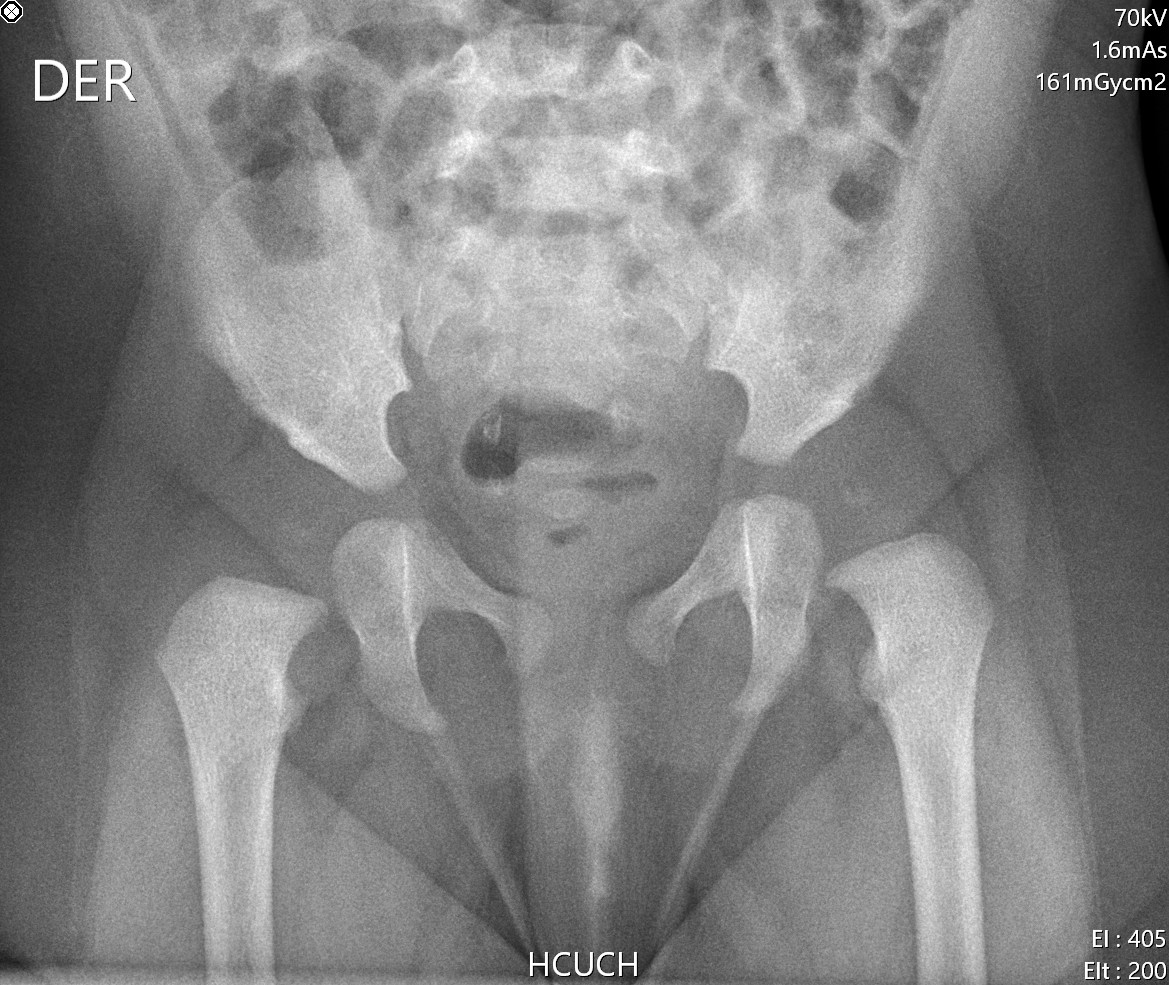

In [6]:
ddh1 = list(data_dir.glob('DDH/*'))
Image.open(str(ddh1[0]))

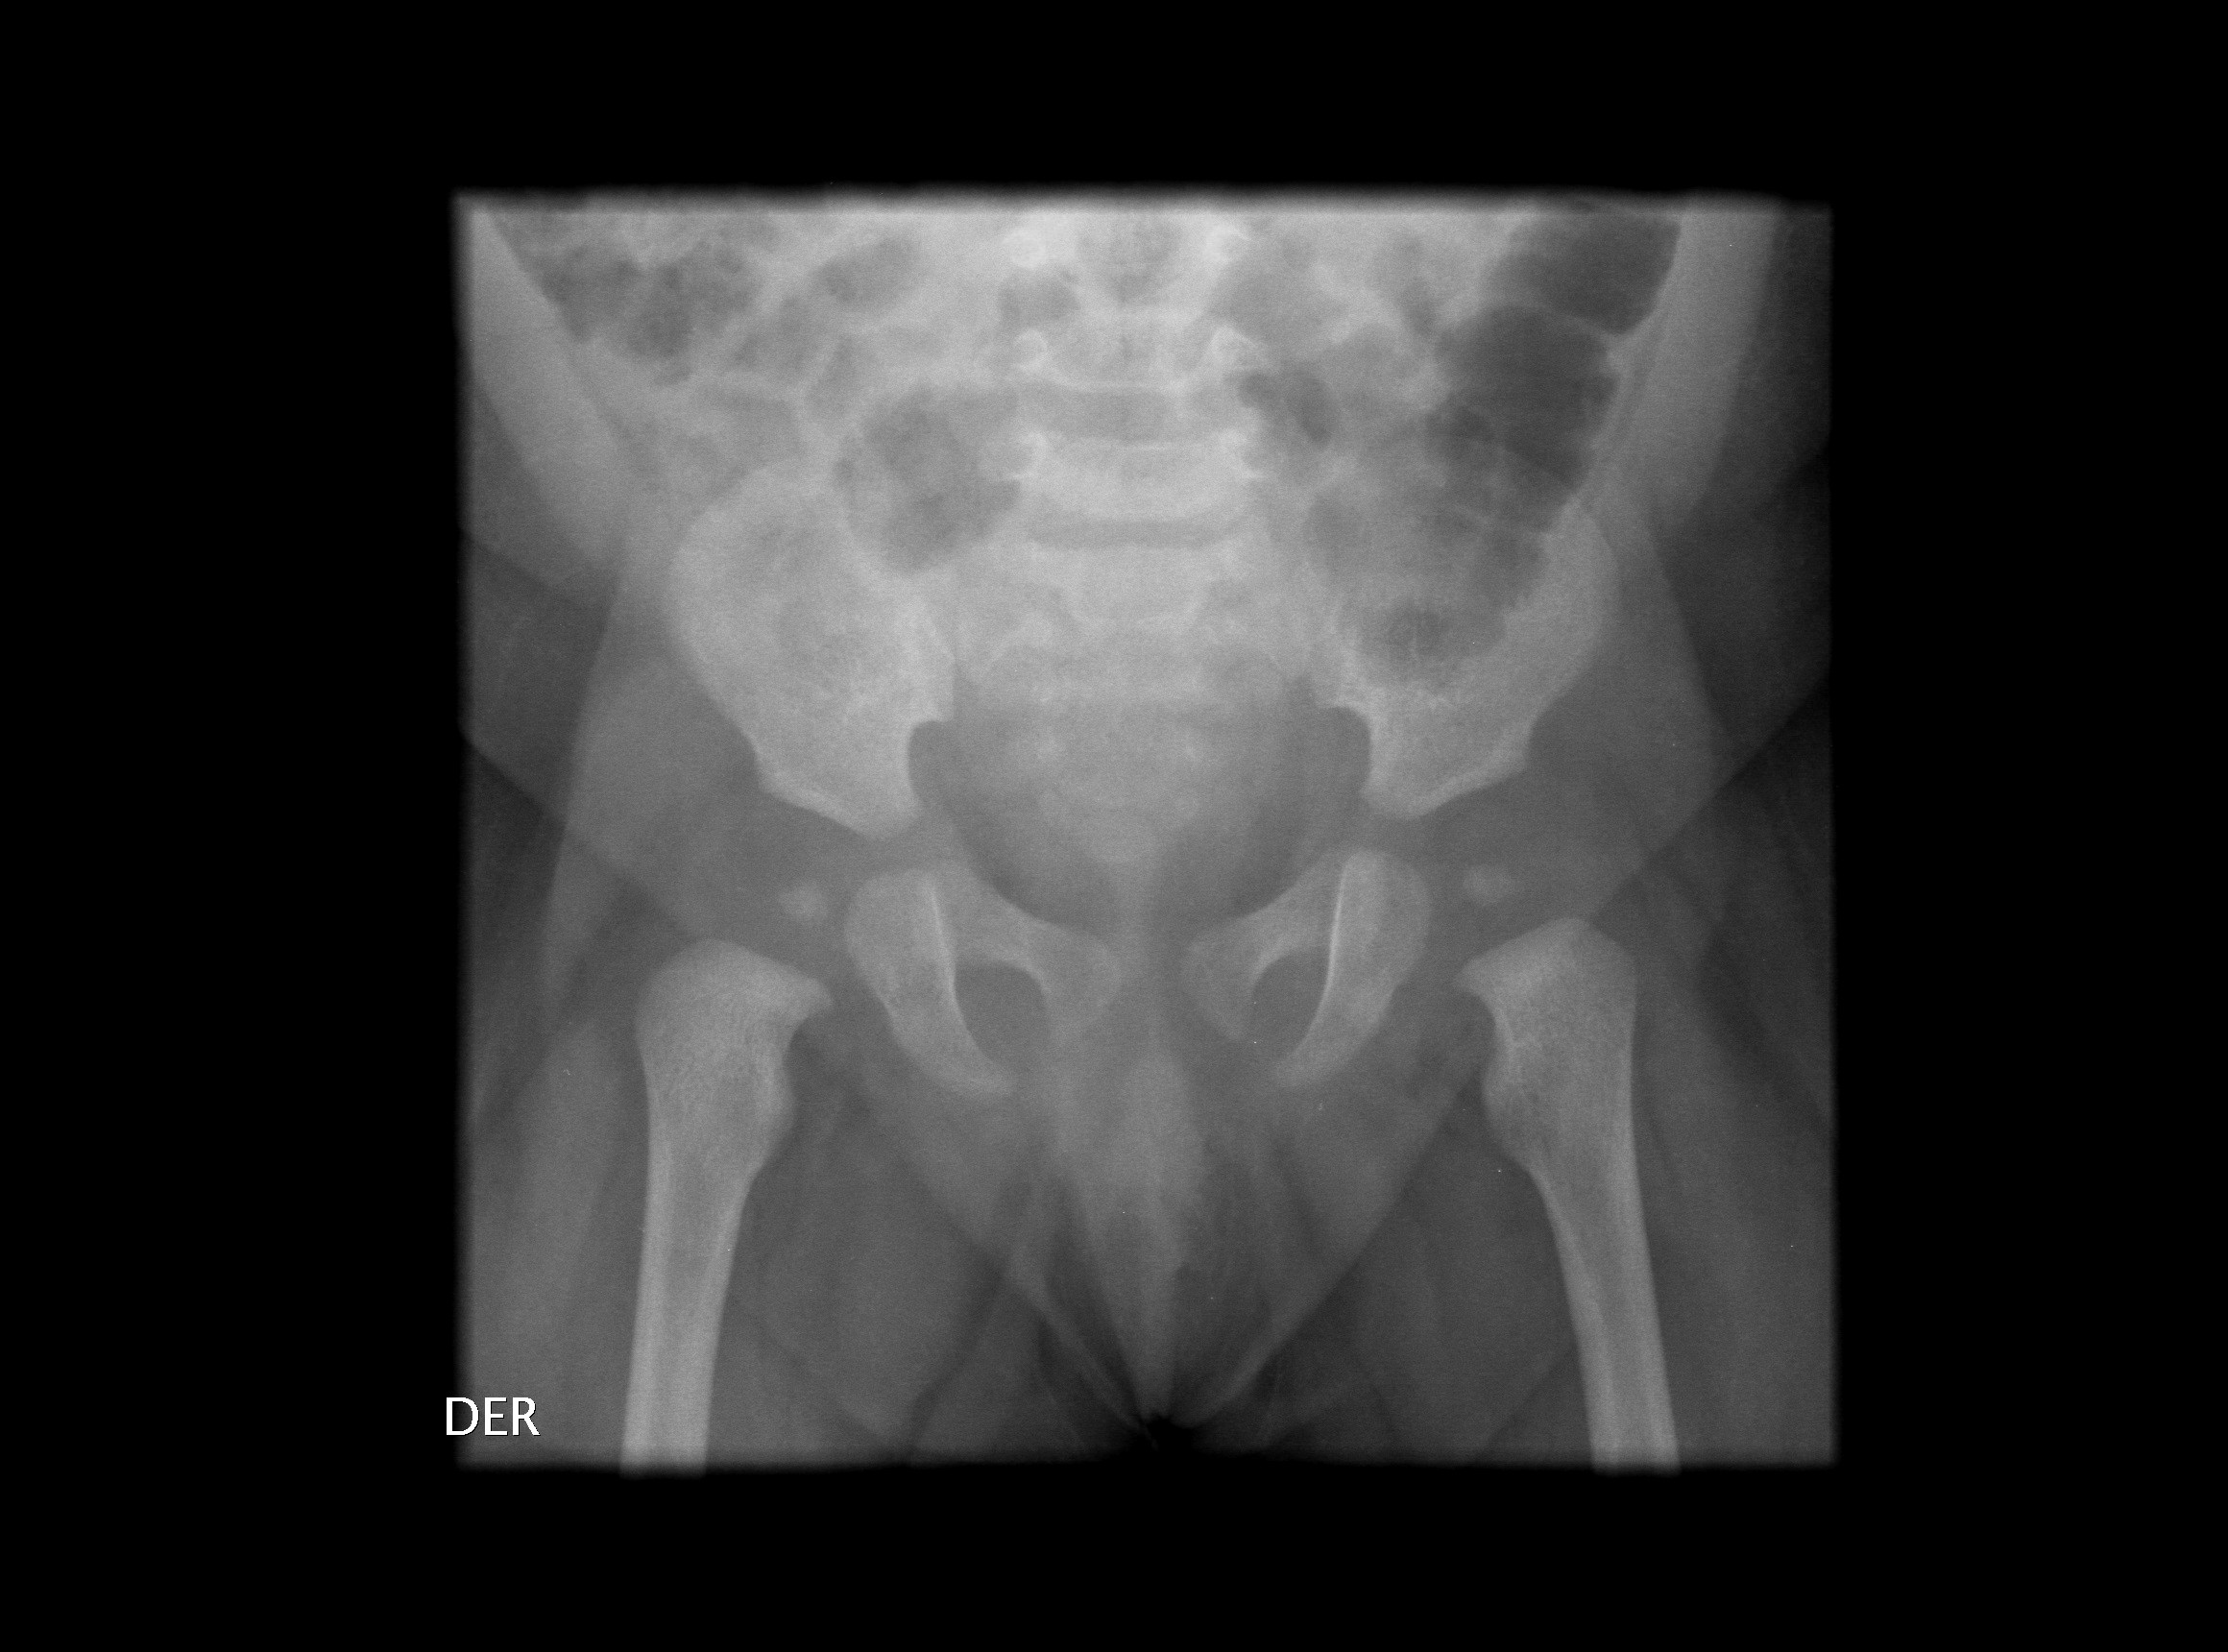

In [7]:
ddh2 = list(data_dir.glob('Normal/*'))
Image.open(str(ddh2[0]))

In [8]:
train_directory= "C:/Users/palma/Downloads/Nueva carpeta (6)/train/"
val_directory="C:/Users/palma/Downloads/Nueva carpeta (6)/val/"
test_directory="C:/Users/palma/Downloads/Nueva carpeta (6)/test/"

In [9]:
data_dir = train_directory
class_names=os.listdir(train_directory)
print(class_names)

['DDH', 'Normal']


In [10]:
IMAGE_SIZE = (160, 160)
# Default batch size
BATCH_SIZE = 32

In [11]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image


In [12]:
train_dataset = tf.keras.utils.image_dataset_from_directory(train_directory,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMAGE_SIZE)


Found 485 files belonging to 2 classes.


In [13]:
validation_dataset = tf.keras.utils.image_dataset_from_directory(val_directory,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMAGE_SIZE)


Found 131 files belonging to 2 classes.


In [14]:
test_dataset = tf.keras.utils.image_dataset_from_directory(test_directory,
                                                                 shuffle=True,
                                                                 batch_size=132,
                                                                 image_size=IMAGE_SIZE)


Found 132 files belonging to 2 classes.


In [15]:
AUTOTUNE = tf.data.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)


In [16]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal"),
    tf.keras.layers.experimental.preprocessing.RandomRotation(5),
    tf.keras.layers.experimental.preprocessing.RandomZoom(0.05)
])

In [17]:
import matplotlib.pyplot as plt

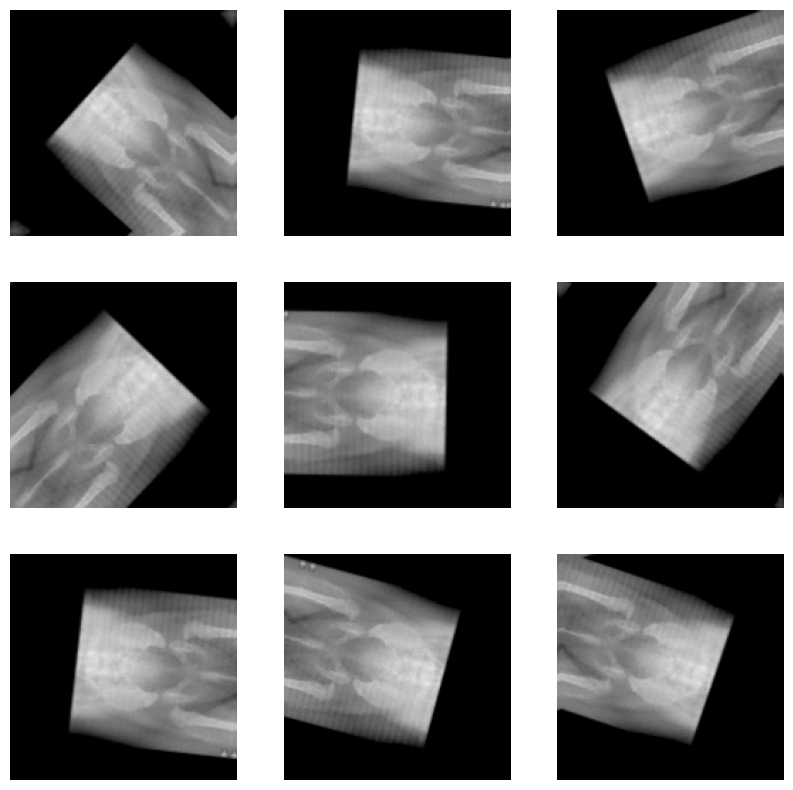

In [18]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

In [19]:
resnet_model = tf.keras.applications.MobileNetV2(input_shape=(160,160,3),
                                               include_top=False,
                                               weights='imagenet')
     

In [20]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
rescale = tf.keras.layers.Rescaling(1./127.5, offset=-1)

In [21]:
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import f1_score
image_batch, label_batch = next(iter(train_dataset))
feature_batch = resnet_model(image_batch)
print(feature_batch.shape)

(32, 5, 5, 1280)


In [22]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


In [23]:
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


In [24]:

for layer in resnet_model.layers:
  layer.trainable = False
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = resnet_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.4)(x)
predictions = prediction_layer(x)
model = tf.keras.Model(inputs=inputs, outputs=predictions)
custom_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005)
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), optimizer=custom_optimizer, metrics=['accuracy'])


In [25]:
from sklearn.utils.class_weight import compute_class_weight

In [26]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                  patience=10)

lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',patience=8)

In [27]:
epoch=10

In [28]:
history = model.fit(train_dataset,
                    epochs=epoch,
                    validation_data=validation_dataset)


Epoch 1/10
16/16 [==============================] - 11s 467ms/step - loss: 0.8932 - accuracy: 0.5072 - val_loss: 0.7583 - val_accuracy: 0.4656
Epoch 2/10
16/16 [==============================] - 8s 444ms/step - loss: 0.7071 - accuracy: 0.5608 - val_loss: 0.6486 - val_accuracy: 0.5115
Epoch 3/10
16/16 [==============================] - 8s 432ms/step - loss: 0.6213 - accuracy: 0.6495 - val_loss: 0.5962 - val_accuracy: 0.5267
Epoch 4/10
16/16 [==============================] - 9s 521ms/step - loss: 0.5327 - accuracy: 0.6928 - val_loss: 0.5934 - val_accuracy: 0.5191
Epoch 5/10
16/16 [==============================] - 9s 482ms/step - loss: 0.5025 - accuracy: 0.7320 - val_loss: 0.6065 - val_accuracy: 0.5191
Epoch 6/10
16/16 [==============================] - 9s 499ms/step - loss: 0.4677 - accuracy: 0.7608 - val_loss: 0.6225 - val_accuracy: 0.5267
Epoch 7/10
16/16 [==============================] - 9s 483ms/step - loss: 0.4193 - accuracy: 0.7938 - val_loss: 0.6634 - val_accuracy: 0.5038
Epoch

In [1]:
score = model.evaluate(train_dataset)

print("Train Loss: ", score[0])
print("Train Accuracy: ", score[1])

score = model.evaluate(test_dataset)
print("\nTest loss: ", score[0])
print("Test Accuracy: ", score[1])

NameError: name 'model' is not defined

In [30]:
from sklearn.metrics import confusion_matrix,classification_report

image_batch, label_batch = next(iter(test_dataset))
predictions = model.predict(image_batch).flatten()

# Apply a sigmoid since our model returns logits
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)
# Generar la matriz de confusión
conf_matrix = confusion_matrix(label_batch, predictions)

report = classification_report(label_batch, predictions)
print(report)

# Imprimir la matriz de confusión
print("Matriz de Confusión:")
print(conf_matrix)

5/5 [==============================] - 2s 238ms/step
Predictions:
 [0 0 0 1 0 0 1 0 0 0 1 1 0 0 0 0 0 0 0 0 1 0 1 1 0 0 0 0 0 1 0 1 0 0 0 1 1
 1 1 1 0 1 1 1 1 0 0 0 0 1 0 0 0 0 1 0 1 1 0 0 0 0 1 0 0 0 0 0 1 0 1 0 0 0
 0 1 0 1 0 1 0 0 0 0 0 0 1 1 1 1 1 1 0 0 0 1 0 0 1 1 1 0 0 1 0 0 0 0 0 1 0
 0 1 0 1 1 0 0 0 0 1 0 0 1 1 0 0 0 0 1 1 1]
Labels:
 tf.Tensor(
[1 1 1 1 0 0 1 0 0 0 1 1 0 0 1 0 0 0 0 1 1 0 1 1 0 1 0 0 1 1 1 1 1 0 0 1 1
 1 1 1 0 1 1 1 1 1 0 0 0 1 1 0 1 0 1 0 1 1 0 0 0 0 1 0 1 0 0 1 1 0 1 0 1 0
 0 1 0 1 0 1 0 0 1 0 0 1 1 1 1 1 1 1 0 0 1 1 1 1 1 1 1 0 1 1 1 0 0 1 1 1 1
 1 1 1 1 1 0 0 0 1 1 0 1 1 1 1 0 1 0 1 1 1], shape=(132,), dtype=int32)
              precision    recall  f1-score   support

           0       0.63      1.00      0.77        52
           1       1.00      0.61      0.76        80

    accuracy                           0.77       132
   macro avg       0.81      0.81      0.77       132
weighted avg       0.85      0.77      0.76       132

Matriz de Confusión:

In [31]:
from tensorflow.keras.preprocessing import image
def classify_image(image_path):
    # Convertir la imagen de PIL a un array de NumPy y preprocesar
    img = image.load_img(image_path, target_size=(160, 160))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)
    predictions = model.predict(img_array).flatten()
    predictions = tf.nn.sigmoid(predictions)
    predictions = tf.where(predictions < 0.5, 0, 1)
    return predictions

Fine tuning

In [32]:
fine_tune_at = 100
for layer in resnet_model.layers[:fine_tune_at]:
    layer.trainable = True

In [33]:
custom_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001/10)
model.compile(loss='binary_crossentropy', optimizer=custom_optimizer, metrics=['accuracy'])


In [34]:
fine_tune_epochs = 10
total_epochs =  epoch+fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset,
                         batch_size=32)




Epoch 10/20
16/16 [==============================] - 28s 1s/step - loss: 1.9577 - accuracy: 0.8124 - val_loss: 3.3236 - val_accuracy: 0.6641
Epoch 11/20
16/16 [==============================] - 20s 1s/step - loss: 1.8569 - accuracy: 0.8247 - val_loss: 3.9874 - val_accuracy: 0.6336
Epoch 12/20
16/16 [==============================] - 23s 1s/step - loss: 1.7354 - accuracy: 0.8186 - val_loss: 3.1660 - val_accuracy: 0.7099
Epoch 13/20
16/16 [==============================] - 23s 1s/step - loss: 1.8188 - accuracy: 0.8227 - val_loss: 3.2480 - val_accuracy: 0.7023
Epoch 14/20
16/16 [==============================] - 23s 1s/step - loss: 2.0484 - accuracy: 0.8000 - val_loss: 2.9909 - val_accuracy: 0.7405
Epoch 15/20
16/16 [==============================] - 23s 1s/step - loss: 1.4785 - accuracy: 0.8289 - val_loss: 2.7089 - val_accuracy: 0.7328
Epoch 16/20
16/16 [==============================] - 24s 1s/step - loss: 1.4136 - accuracy: 0.8680 - val_loss: 2.6742 - val_accuracy: 0.7252
Epoch 17/20
1

In [35]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)
print('Test loss :', loss)

1/1 [==============================] - 2s 2s/step - loss: 0.5091 - accuracy: 0.8864
Test accuracy : 0.8863636255264282
Test loss : 0.5090686082839966


In [36]:
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

# Apply a sigmoid since our model returns logits
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)
# Generar la matriz de confusión
conf_matrix = confusion_matrix(label_batch, predictions)

report = classification_report(label_batch, predictions)
print(report)

# Imprimir la matriz de confusión
print("Matriz de Confusión:")
print(conf_matrix)

Predictions:
 [1 1 0 0 0 1 1 0 1 0 1 1 1 1 1 1 1 1 1 0 0 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1
 1 1 0 1 0 1 1 1 1 0 0 1 0 1 0 1 0 1 1 1 1 1 0 1 1 0 1 0 0 1 0 0 0 1 1 0 1
 1 1 1 0 0 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1 0 0 0 1 1 1 1 1 0 1 1 0 1 0 1 1 1
 1 1 0 0 1 0 0 0 0 1 1 0 1 0 1 1 0 1 1 1 0]
Labels:
 [1 0 0 0 0 1 1 0 1 1 1 0 1 0 1 1 1 1 1 0 0 1 1 1 1 1 1 1 1 0 1 1 1 1 0 0 1
 1 1 0 1 0 1 1 1 1 1 0 1 0 1 0 1 0 1 1 1 0 1 0 1 1 0 1 0 0 1 0 0 0 1 1 0 1
 1 1 1 0 0 1 1 1 0 0 1 0 0 1 0 0 1 1 1 0 1 0 0 1 1 1 1 1 0 1 1 0 1 0 1 1 1
 0 1 0 0 1 0 0 0 0 1 1 0 1 0 1 1 0 1 1 1 0]
              precision    recall  f1-score   support

           0       0.93      0.77      0.84        52
           1       0.87      0.96      0.91        80

    accuracy                           0.89       132
   macro avg       0.90      0.87      0.88       132
weighted avg       0.89      0.89      0.88       132

Matriz de Confusión:
[[40 12]
 [ 3 77]]


In [37]:
from tensorflow.keras.preprocessing import image
def classify_image(image_path):
    # Convertir la imagen de PIL a un array de NumPy y preprocesar
    img = image.load_img(image_path, target_size=(160, 160))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    predictions = model.predict(img_array).flatten()
    predictions = tf.nn.sigmoid(predictions)
    predictions = tf.where(predictions < 0.5, 0, 1)
    return predictions

In [37]:
model.save('MobileNet')

INFO:tensorflow:Assets written to: MobileNet\assets


INFO:tensorflow:Assets written to: MobileNet\assets


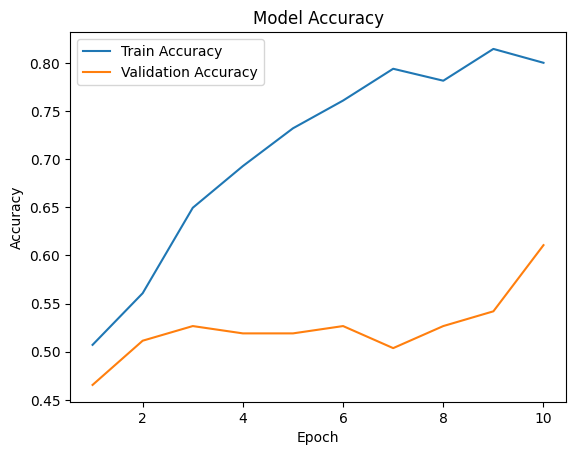

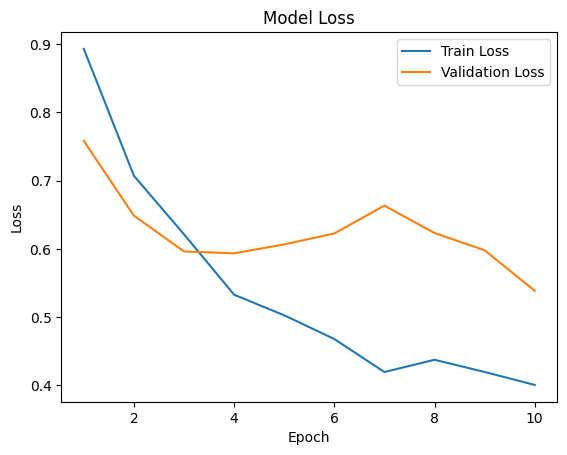

In [3]:
train_loss = [0.8932, 0.7071, 0.6213, 0.5327, 0.5025, 0.4677, 0.4193, 0.4373, 0.4194, 0.4004]
train_accuracy = [0.5072, 0.5608, 0.6495, 0.6928, 0.7320, 0.7608, 0.7938, 0.7814, 0.8144, 0.8000]

val_loss = [0.7583, 0.6486, 0.5962, 0.5934, 0.6065, 0.6225, 0.6634, 0.6232, 0.5979, 0.5385]
val_accuracy = [0.4656, 0.5115, 0.5267, 0.5191, 0.5191, 0.5267, 0.5038, 0.5267, 0.5420, 0.6107]

# Generar la lista de épocas automáticamente
epochs = list(range(1, len(train_loss) + 1))

# Plot accuracy
plt.plot(epochs, train_accuracy, label='Train Accuracy')
plt.plot(epochs, val_accuracy, label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot loss
plt.plot(epochs, train_loss, label='Train Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

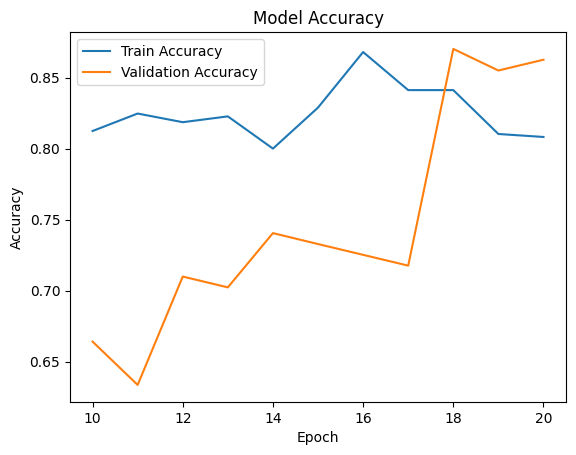

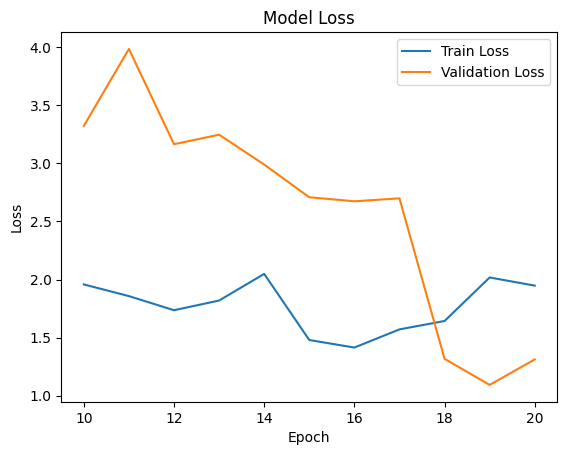

In [4]:
train_loss = [1.9577, 1.8569, 1.7354, 1.8188, 2.0484, 1.4785, 1.4136, 1.5701, 1.6424, 2.0176, 1.9474]
train_accuracy = [0.8124, 0.8247, 0.8186, 0.8227, 0.8000, 0.8289, 0.8680, 0.8412, 0.8412, 0.8103, 0.8082]

val_loss = [3.3236, 3.9874, 3.1660, 3.2480, 2.9909, 2.7089, 2.6742, 2.6994, 1.3165, 1.0915, 1.3113]
val_accuracy = [0.6641, 0.6336, 0.7099, 0.7023, 0.7405, 0.7328, 0.7252, 0.7176, 0.8702, 0.8550, 0.8626]

# Generar la lista de épocas automáticamente
epochs = list(range(10, 21))

# Plot accuracy
plt.plot(epochs, train_accuracy, label='Train Accuracy')
plt.plot(epochs, val_accuracy, label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot loss
plt.plot(epochs, train_loss, label='Train Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()